In [1]:
%pip install BERTopic

Note: you may need to restart the kernel to use updated packages.


In [75]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import seaborn as sns
from sklearn.feature_selection import r_regression

In [16]:
ufo_data = pd.read_csv("complete.csv", on_bad_lines = "skip")
ufo_data["comments"] = ufo_data["comments"].astype("str")
comments = ufo_data["comments"]

C:\Users\alden\AppData\Local\Temp\ipykernel_45348\3462774876.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ufo_data = pd.read_csv("complete.csv", on_bad_lines = "skip")


In [18]:
# Code in this block comes from midterm 2.

# KeyBERTInspired is used to help describe clusters.
representation_model = KeyBERTInspired()

# ChatGPT recommended using all-mpnet-base-v2 rather than default model because
# it better understands text meaning so reduces outliers in clusters.
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# In BERTopic, embedding_model converts text to numbers, not just by words
# but by meaning using behind the scenes language model capabilities, so that
# the text can actually be clustered. The representation model then tries to
# describe clusters through keywords.

# multilingual to account for variety of review languages.
topic_model = BERTopic(representation_model=representation_model, embedding_model= embedding_model, language = "multilingual", verbose = True)
# topics is list of review cluster for each row of restaurant_data (clusters
# are just numbered so topics is a list of ints)
topics, probs = topic_model.fit_transform(comments)

2025-05-03 11:15:24,579 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2772 [00:00<?, ?it/s]

2025-05-03 12:06:11,275 - BERTopic - Embedding - Completed ✓
2025-05-03 12:06:11,275 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-03 12:07:07,053 - BERTopic - Dimensionality - Completed ✓
2025-05-03 12:07:07,061 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-03 12:07:25,710 - BERTopic - Cluster - Completed ✓
2025-05-03 12:07:25,719 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-03 12:10:56,318 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.visualize_barchart()

In [22]:
ufo_data["Topic Number"] = topics

In [24]:
print(ufo_data["Topic Number"].value_counts())

Topic Number
-1      49499
 0       4004
 1       1494
 2       1041
 3       1006
        ...  
 512       10
 513       10
 514       10
 515       10
 516       10
Name: count, Length: 518, dtype: int64


In [25]:
ufo_data["datetime"] = ufo_data["datetime"].apply(
    lambda x: x if not x.endswith("24:00") else x[:-5] + "00:00"
)

ufo_data["datetime"] = pd.to_datetime(ufo_data["datetime"])
ufo_data["Year"] = ufo_data["datetime"].dt.year
print(ufo_data["Year"].head())

0    1949
1    1949
2    1955
3    1956
4    1960
Name: Year, dtype: int32


In [29]:
year_counts = ufo_data.groupby(["Year", "Topic Number"])["Topic Number"].count()
print(year_counts)

Year  Topic Number
1906  -1              1
1910  -1              1
       3              1
       7              1
1914  -1              1
                     ..
2014   496            1
       497            2
       505            2
       514            1
       516            1
Name: Topic Number, Length: 8843, dtype: int64


In [37]:
year_counts_frame = pd.DataFrame()
year_counts_frame["Topic Count"] = year_counts
year_counts_frame.reset_index(inplace = True)

In [38]:
print(year_counts_frame.columns)

Index(['Year', 'Topic Number', 'Topic Count'], dtype='object')


In [42]:
us_population_data = pd.read_csv("fred_population.csv")
us_population_data["observation_date"] = pd.to_datetime(us_population_data["observation_date"])
us_population_data["Year"] = us_population_data["observation_date"].dt.year
print(us_population_data["Year"].head())

0    1960
1    1961
2    1962
3    1963
4    1964
Name: Year, dtype: int32


In [49]:
year_counts_frame = year_counts_frame.merge(right = us_population_data, how = "inner", on = "Year")
print(year_counts_frame)

      Year  Topic Number  Topic Count observation_date  POPTOTUSA647NWDB
0     1960            -1           36       1960-01-01         180671000
1     1960             1            1       1960-01-01         180671000
2     1960             3            4       1960-01-01         180671000
3     1960             4            3       1960-01-01         180671000
4     1960             7            1       1960-01-01         180671000
...    ...           ...          ...              ...               ...
8574  2014           496            1       2014-01-01         318386329
8575  2014           497            2       2014-01-01         318386329
8576  2014           505            2       2014-01-01         318386329
8577  2014           514            1       2014-01-01         318386329
8578  2014           516            1       2014-01-01         318386329

[8579 rows x 5 columns]


In [51]:
year_counts_frame["Topic Count per Capita"] = year_counts_frame["Topic Count"] / year_counts_frame["POPTOTUSA647NWDB"]
print(year_counts_frame)

      Year  Topic Number  Topic Count observation_date  POPTOTUSA647NWDB  \
0     1960            -1           36       1960-01-01         180671000   
1     1960             1            1       1960-01-01         180671000   
2     1960             3            4       1960-01-01         180671000   
3     1960             4            3       1960-01-01         180671000   
4     1960             7            1       1960-01-01         180671000   
...    ...           ...          ...              ...               ...   
8574  2014           496            1       2014-01-01         318386329   
8575  2014           497            2       2014-01-01         318386329   
8576  2014           505            2       2014-01-01         318386329   
8577  2014           514            1       2014-01-01         318386329   
8578  2014           516            1       2014-01-01         318386329   

      Topic Count per Capita  
0               1.992572e-07  
1               5.534923e

In [77]:
for i in range(10):
    print("Topic: " + str(i))
    topic_data = year_counts_frame[year_counts_frame["Topic Number"] == i]
    r_value = r_regression(topic_data[["Year"]], topic_data["Topic Count per Capita"])
    print(r_v)
    plt.scatter(x = topic_data["Year"], y = topic_data["Topic Count per Capita"])
    plt.show()

Topic: 0


NameError: name 'r_v' is not defined

In [54]:
total_reports_by_year = ufo_data.groupby(["Year"])["Year"].count()
print(total_reports_by_year)

Year
1906       1
1910       3
1914       1
1916       1
1917       1
        ... 
2010    4690
2011    5521
2012    7925
2013    7598
2014    2473
Name: Year, Length: 90, dtype: int64


In [56]:
year_counts_frame["Yearly Total"] = \
    year_counts_frame["Year"].apply(lambda x: total_reports_by_year[x])
print(year_counts_frame)

      Year  Topic Number  Topic Count observation_date  POPTOTUSA647NWDB  \
0     1960            -1           36       1960-01-01         180671000   
1     1960             1            1       1960-01-01         180671000   
2     1960             3            4       1960-01-01         180671000   
3     1960             4            3       1960-01-01         180671000   
4     1960             7            1       1960-01-01         180671000   
...    ...           ...          ...              ...               ...   
8574  2014           496            1       2014-01-01         318386329   
8575  2014           497            2       2014-01-01         318386329   
8576  2014           505            2       2014-01-01         318386329   
8577  2014           514            1       2014-01-01         318386329   
8578  2014           516            1       2014-01-01         318386329   

      Topic Count per Capita  Yearly Total  
0               1.992572e-07            77

In [64]:
year_counts_frame["Yearly Topic Proportion"] = year_counts_frame["Topic Count"]/ year_counts_frame["Yearly Total"] * 100
print(year_counts_frame)

      Year  Topic Number  Topic Count observation_date  POPTOTUSA647NWDB  \
0     1960            -1           36       1960-01-01         180671000   
1     1960             1            1       1960-01-01         180671000   
2     1960             3            4       1960-01-01         180671000   
3     1960             4            3       1960-01-01         180671000   
4     1960             7            1       1960-01-01         180671000   
...    ...           ...          ...              ...               ...   
8574  2014           496            1       2014-01-01         318386329   
8575  2014           497            2       2014-01-01         318386329   
8576  2014           505            2       2014-01-01         318386329   
8577  2014           514            1       2014-01-01         318386329   
8578  2014           516            1       2014-01-01         318386329   

      Topic Count per Capita  Yearly Total  Yearly Topic Proportion  
0               1

Topic: 0
[0.57614644]


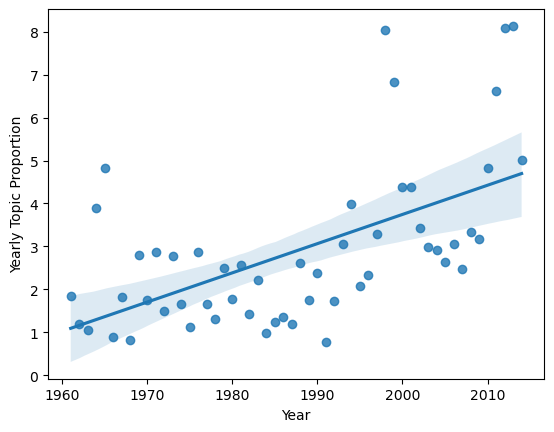

Topic: 1
[-0.6394867]


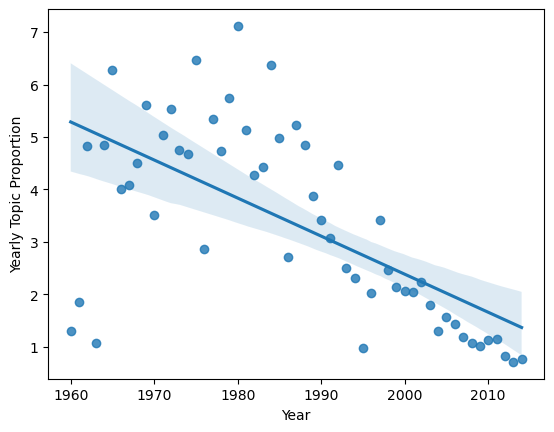

Topic: 2
[0.49473155]


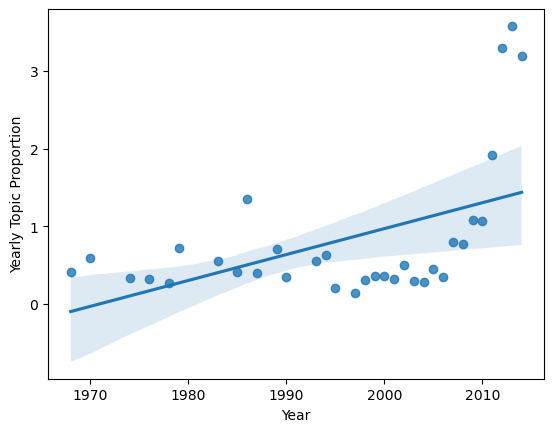

Topic: 3
[-0.57738982]


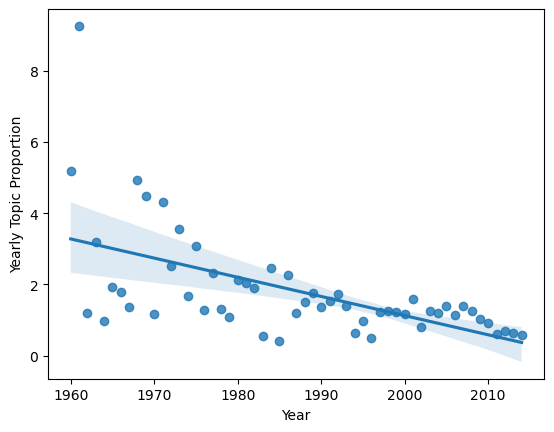

Topic: 4
[-0.70674664]


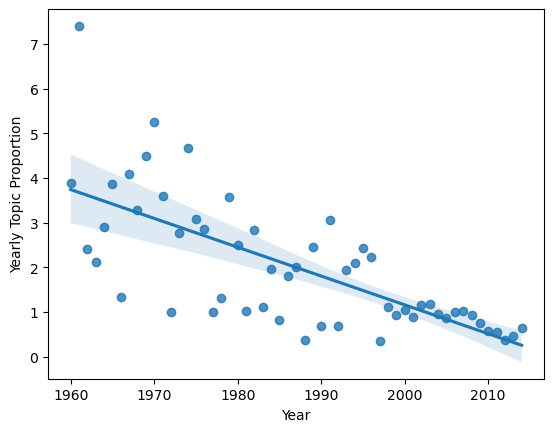

Topic: 5
[-0.14717043]


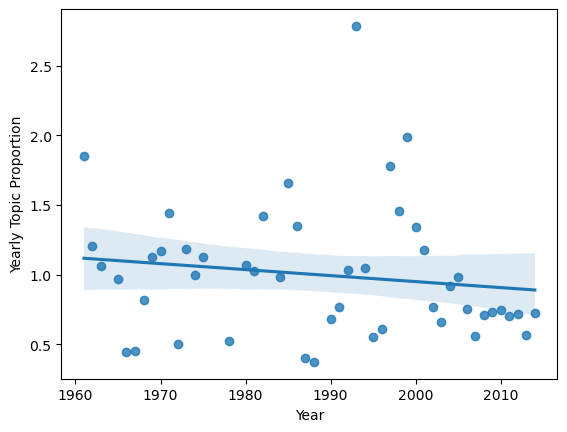

Topic: 6
[0.18169842]


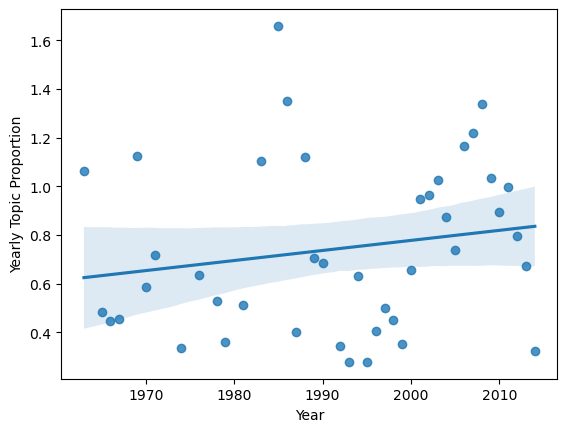

Topic: 7
[-0.67012401]


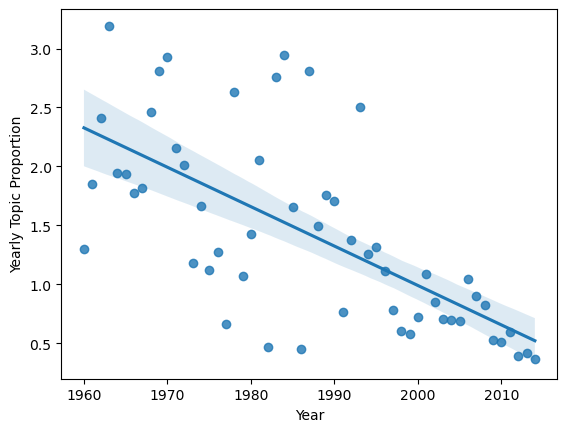

Topic: 8
[-0.30667732]


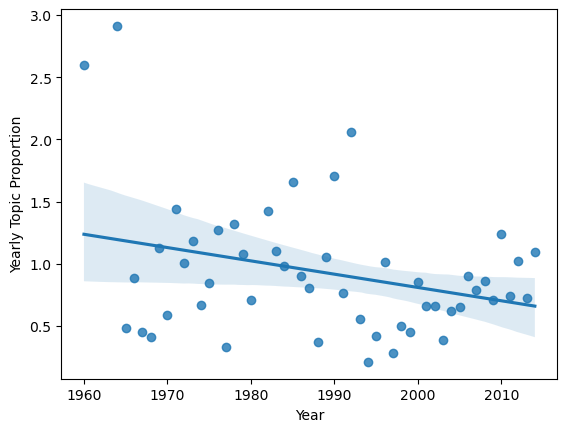

Topic: 9
[0.23634513]


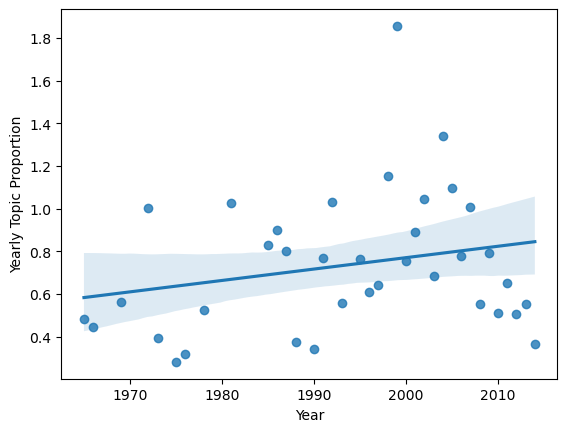

In [80]:
for i in range(10):
    print("Topic: " + str(i))
    topic_data = year_counts_frame[year_counts_frame["Topic Number"] == i]
    r_value = r_regression(topic_data[["Year"]], topic_data["Yearly Topic Proportion"])
    print(r_value)
    sns.regplot(data = topic_data, x = "Year", y = "Yearly Topic Proportion")
    plt.show()

In [89]:
ufo_data["duration (seconds)"] = ufo_data["duration (seconds)"].astype(str).str.replace("`", "")
ufo_data["duration (seconds)"] = ufo_data["duration (seconds)"].astype("float")
print(ufo_data["duration (seconds)"])

0        2700.0
1        7200.0
2          20.0
3          20.0
4         900.0
          ...  
88674    1200.0
88675       5.0
88676    1020.0
88677       0.0
88678       0.0
Name: duration (seconds), Length: 88679, dtype: float64


In [119]:
ufo_data["duration (seconds)"] = ufo_data["duration (seconds)"].astype(str).str.replace("`", "")
ufo_data["duration (seconds)"] = ufo_data["duration (seconds)"].astype("float")
ufo_data["duration (seconds)"].describe()
percentile_96 = ufo_data["duration (seconds)"].quantile(0.96)
print(percentile_96)

3600.0


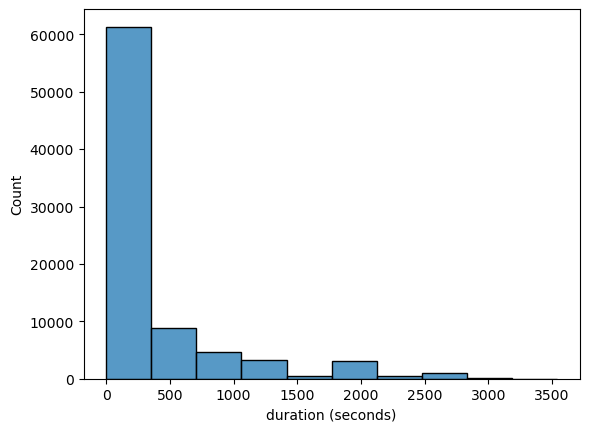

In [127]:
sns.histplot(ufo_data[(ufo_data["duration (seconds)"] < percentile_96)], x = "duration (seconds)", bins = 10)
plt.show()